# Web Scraping Stock Data

In [1]:
#import the basics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [2]:
#allow to use own functions from functions.py
import os
os.getcwd()

'C:\\Users\\Stijn\\Documents\\GitHub\\stock-scraping'

In [3]:
ticker = "ASML.AS"

In [4]:
#TO DO:

In [5]:
#summary
url_summary = "https://finance.yahoo.com/quote/"+ ticker + "?p=" + ticker + "&.tsrc=fin-srch"
url_summary

'https://finance.yahoo.com/quote/ASML.AS?p=ASML.AS&.tsrc=fin-srch'

In [6]:
#analysis by analysts
url_analists = "https://finance.yahoo.com/quote/" + ticker + "/analysis?p=" + ticker

In [7]:
#sustainability
url_sust = "https://finance.yahoo.com/quote/" + ticker + "/sustainability?p=" + ticker

## Financials

In [4]:
from functions import income_statement

In [5]:
cf_abi = income_statement('ABI.BR', 'cash-flow')

In [6]:
cf_abi

Breakdown,Operating Cash Flow,Investing Cash Flow,Financing Cash Flow,Cash Flow from Discontinued Operation,End Cash Position,Capital Expenditure,Issuance of Capital Stock,Issuance of Debt,Repayment of Debt,Free Cash Flow
12/31/2018,14663000,-3965000,-13945000,0,6960000,-5086000,0,17782000,-22489000,9577000
12/31/2019,13396000,-5073000,-8512000,539000,7169000,-5174000,5575000,22584000,-31033000,8222000
12/31/2020,10891000,6336000,-8475000,0,15247000,-3781000,0,14822000,-23577000,7110000
12/31/2021,14799000,-5878000,-11598000,0,12043000,-5640000,0,454000,-9496000,9159000
ttm,14799000,-5878000,-11598000,0,12043000,-5640000,0,454000,-9496000,9159000


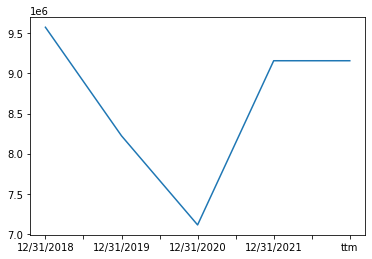

In [7]:
cf_abi['Free Cash Flow'].plot()
plt.show()

## Statistics

In [8]:
from functions import statistics

In [9]:
stat_googl = statistics('GOOGL')

In [10]:
stat_googl.head()

,parameter,value
0,Market Cap (intraday),1.44T
1,Enterprise Value,1.33T
2,Trailing P/E,19.71
3,Forward P/E,19.19
4,PEG Ratio (5 yr expected),0.77


## Historical Data

In [11]:
from functions import hist_stock_price
from functions import plot_sp
from functions import relative_diff

In [12]:
ASML_sp = hist_stock_price('ASML.AS', 2021, 4, 25)

In [13]:
ASML_sp.head()

,Date,Open,High,Low,Close,Adj_Close,Volume
0,2021-04-26,554.900024,557.700012,550.000000,557.000000,550.144104,556857
1,2021-04-27,555.000000,559.400024,547.500000,552.700012,545.897034,698811
2,2021-04-28,552.700012,555.000000,548.099976,549.799988,543.032715,508201
3,2021-04-29,549.799988,557.099976,541.400024,542.799988,536.118896,699373
4,2021-04-30,542.599976,547.500000,538.900024,541.200012,534.538574,729987


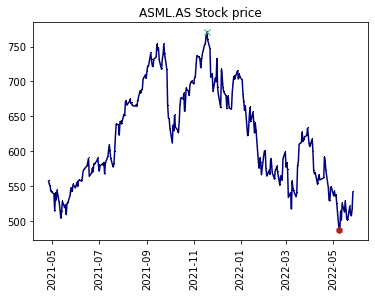

In [14]:
plot_sp('ASML.AS', 2021, 4, 25)

In [15]:
relative_diff(ASML_sp, 6)

Relative difference 3 months: -23.2% [compared to 2021-11-29]


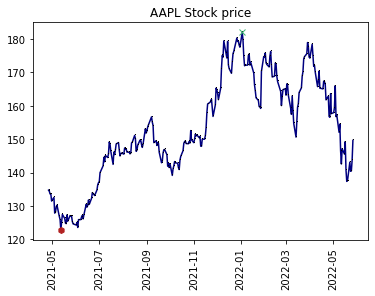

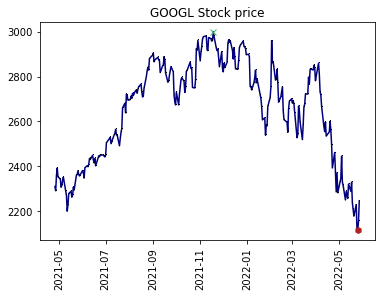

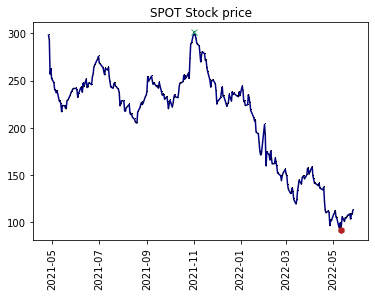

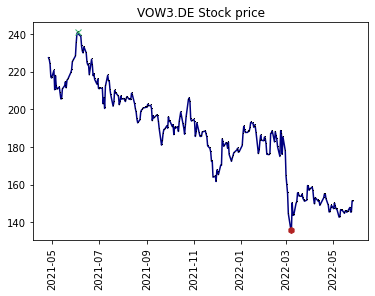

In [16]:
stocks = ["AAPL", "GOOGL", "SPOT", "VOW3.DE"]

for stock in stocks:
    plot_sp(stock, 2021, 4, 25)

In [ ]:
#old code

In [ ]:
def plot_sp2(ticker):
    dataset = hist_stock_price(ticker)
    
    d = {}
    for i in range(len(dataset[dataset.Open == 0])):
        d["div_date_{0}".format(i)] = dataset.loc[dataset.Open == 0, 'Date'].iloc[i] #get the date of dividend
        d["div_date_index_{0}".format(i)] = dataset.loc[dataset.Open == 0].index[i] #get the index of the dividend line
        d["div_value_{0}".format(i)] = dataset.iloc[dataset.loc[dataset.Open == 0].index[i]-2, 5] #get the value at closing of the dividend day
    
    dataset = dataset.drop(dataset[dataset.Open == 0].index) #remove dividend line(s)
    
    #create plot
    plt.plot('Date', 'Close*', data = dataset)
    plt.grid()
    plt.title(str(ticker) + " Stock price")
    for i in range(int(len(d)/3)):
        #plt.annotate("Dividend", (d['div_date_{0}'.format(i)], d['div_value_{0}'.format(i)] + d['div_value_{0}'.format(i)]/40))
        plt.plot(d['div_date_{0}'.format(i)], d['div_value_{0}'.format(i)], '.', color='black')
    plt.xticks(rotation='90')
    plt.show()